# Download OTG 20022712 L2G

In [1]:
import gc
import json
import time
from ftplib import FTP
from pathlib import Path
from urllib.request import urlopen

import numpy as np
import scipy as sp
import scipy.sparse as spp
import scanpy as sc

from tqdm.auto import tqdm
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt

from pyannotables import tables

In [2]:
import genetics

In [3]:
pd.set_option('display.max_columns', None)

## Fetch study JSON files from FTP

In [4]:
url_root = 'ftp.ebi.ac.uk'
json_dir = '/pub/databases/opentargets/genetics/20022712/lut/study-index'


ftp = FTP(url_root)
ftp.login()
ftp.cwd(json_dir)

files = []
cb = lambda x: files.append(x.split()[8]) if "SUCCESS" not in x else None

code = ftp.retrlines('LIST', callback=cb)

In [5]:
files[:5]

['part-00000-ca60ef53-4b47-4464-a320-0c78c6238fc6-c000.json',
 'part-00001-ca60ef53-4b47-4464-a320-0c78c6238fc6-c000.json',
 'part-00002-ca60ef53-4b47-4464-a320-0c78c6238fc6-c000.json',
 'part-00003-ca60ef53-4b47-4464-a320-0c78c6238fc6-c000.json',
 'part-00004-ca60ef53-4b47-4464-a320-0c78c6238fc6-c000.json']

## Parse study JSON files

In [7]:
studies = []

for f in tqdm(files):

    file_url = f'http://{url_root}{json_dir}/{f}'
    json_url = urlopen(file_url) 
    df = json_normalize([json.loads(x.decode('utf-8')) for x in json_url.readlines()])
    studies.append(df)
    
studies = pd.concat(studies, axis=0).reset_index(drop=True)

In [8]:
studies.head()

,study_id,pmid,pub_date,pub_journal,pub_title,pub_author,trait_reported,ancestry_initial,n_initial,n_cases,trait_category,num_assoc_loci,has_sumstats,trait_efos,ancestry_replication,n_replication
0,GCST000001,PMID:15761122,2005-03-10,Science,Complement factor H polymorphism in age-relate...,Klein RJ,Age-related macular degeneration,[European=146],146,96.0,Nervous system,1,False,[EFO_0001365],NaN,NaN
1,GCST000002,PMID:16252231,2005-09-09,Am J Hum Genet,High-resolution whole-genome association study...,Maraganore DM,Parkinson's disease,"[Asian unspecified=1, European=744, Other=141]",886,NaN,Nervous system,0,False,[EFO_0002508],"[Other=122, Asian unspecified=1, European=541]",664.0
2,GCST000003,PMID:16614226,2006-04-14,Science,A common genetic variant is associated with ad...,Herbert A,Obesity,[NR=694],694,NaN,Disease,0,False,[EFO_0001073],"[European=10527, African American or Afro-Cari...",11622.0
3,GCST000004,PMID:16648850,2006-04-30,Nat Genet,A common genetic variant in the NOS1 regulator...,Arking DE,QT interval,[European=200],200,NaN,Cardiovascular measurement,1,False,[EFO_0004682],[European=4851],4851.0
4,GCST000005,PMID:17052657,2006-09-28,Lancet Neurol,Genome-wide genotyping in Parkinson's disease ...,Fung HC,Parkinson's disease,[European=537],537,267.0,Nervous system,0,False,[EFO_0002508],NaN,NaN


In [9]:
studies.shape

(19267, 16)

In [10]:
studies.trait_reported.nunique()

16100

In [11]:
studies.trait_efos.astype(str).nunique()

4747

## Fetch study and variant info through GraphQL

In [12]:
all_studies = sorted(list(set(studies.study_id.tolist())))

In [13]:
len(all_studies)

19267

In [14]:
split_studies = np.array_split(all_studies, 400)

In [15]:
api = genetics.Genetics()

In [16]:
api.study_info(split_studies[0]).head()

,studyId,traitReported,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumsStats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,nTotal,traitCategory,numAssocLoci
0,GCST000001,Age-related macular degeneration,[EFO_0001365],PMID:15761122,2005-03-10,Science,Complement factor H polymorphism in age-relate...,Klein RJ,False,[European=146],[],146,NaN,96.0,146,Nervous system,1
1,GCST000002,Parkinson's disease,[EFO_0002508],PMID:16252231,2005-09-09,Am J Hum Genet,High-resolution whole-genome association study...,Maraganore DM,False,"[Asian unspecified=1, European=744, Other=141]","[Other=122, Asian unspecified=1, European=541]",886,664.0,NaN,1550,Nervous system,0
2,GCST000003,Obesity,[EFO_0001073],PMID:16614226,2006-04-14,Science,A common genetic variant is associated with ad...,Herbert A,False,[NR=694],"[European=10527, African American or Afro-Cari...",694,11622.0,NaN,12316,Disease,0
3,GCST000004,QT interval,[EFO_0004682],PMID:16648850,2006-04-30,Nat Genet,A common genetic variant in the NOS1 regulator...,Arking DE,False,[European=200],[European=4851],200,4851.0,NaN,5051,Cardiovascular measurement,1
4,GCST000005,Parkinson's disease,[EFO_0002508],PMID:17052657,2006-09-28,Lancet Neurol,Genome-wide genotyping in Parkinson's disease ...,Fung HC,False,[European=537],[],537,NaN,267.0,537,Nervous system,0


In [17]:
df = api.manhattan(split_studies[0][:10])
df

,bestGenes,bestColocGenes,bestLocus2Genes,pval,pvalMantissa,pvalExponent,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,credibleSetSize,ldSetSize,totalSetSize,variant_id,variant_idB37,variant_rsId,variant_chromosome,variant_position,variant_chromosomeB37,variant_positionB37,variant_refAllele,variant_altAllele,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_tss,variant_nearestGene_bioType,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestGeneDistance,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_tss,variant_nearestCodingGene_bioType,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,study
0,"[{'gene': {'id': 'ENSG00000116785', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000000971', 'symbol': ...",4.000000e-08,4,-8,None,None,None,None,None,None,None,None,147,147,1_196731921_G_C,1_196701051_G_C,rs380390,1,196731921,1,196701051,G,C,ENSG00000116785,CFHR3,complement factor H related 3 [Source:HGNC Sym...,1,196774795,196795406,196774795,protein_coding,True,"[196793317, 196794073, 196790045, 196790227, 1...",42874,ENSG00000116785,CFHR3,complement factor H related 3 [Source:HGNC Sym...,1,196774795,196795406,196774795,protein_coding,True,"[196793317, 196794073, 196790045, 196790227, 1...",42874,intron_variant,-0.529929,0.070,0.732582,0.777778,0.656250,0.957584,0.526301,0.577600,0.567763,0.576438,0.603774,0.602070,0.607407,GCST000001
1,"[{'gene': {'id': 'ENSG00000198929', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000198929', 'symbol': ...",1.000000e-10,1,-10,None,None,None,None,None,None,None,None,166,166,1_162115895_G_T,1_162085685_G_T,rs10494366,1,162115895,1,162085685,G,T,ENSG00000198929,NOS1AP,nitric oxide synthase 1 adaptor protein [Sourc...,1,162069691,162370475,162069691,protein_coding,True,"[162154405, 162154476, 162069691, 162070282, 1...",46204,ENSG00000198929,NOS1AP,nitric oxide synthase 1 adaptor protein [Sourc...,1,162069691,162370475,162069691,protein_coding,True,"[162154405, 162154476, 162069691, 162070282, 1...",46204,intron_variant,-0.341761,0.273,0.381600,0.587470,0.568966,0.306804,0.640104,0.651405,0.703016,0.635599,0.547170,0.609287,0.592251,GCST000004
2,"[{'gene': {'id': 'ENSG00000254636', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000254636', 'symbol': ...",8.000000e-12,8,-12,1.6,1.39835,1.83072,None,None,None,+,None,39,39,10_122461028_G_A,10_124220544_G_A,rs11200638,10,122461028,10,124220544,G,A,ENSG00000285955,BX842242.1,novel transcript,10,122435924,122461383,122461383,antisense,False,"[122435924, 122436632, 122458495, 122459911, 1...",355,ENSG00000166033,HTRA1,HtrA serine peptidase 1 [Source:HGNC Symbol;Ac...,10,122458551,122514907,122458551,protein_coding,True,"[122489422, 122489626, 122488902, 122489001, 1...",2477,upstream_gene_variant,0.320441,7.475,0.243274,0.274764,0.218750,0.430968,0.238905,0.234889,0.294956,0.210624,0.198113,0.205993,0.258333,GCST000006
3,"[{'gene': {'id': 'ENSG00000167207', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000167207', 'symbol': ...",5.000000e-10,5,-10,None,None,None,None,None,None,None,None,17,17,16_50722970_A_G,16_50756881_A_G,rs2076756,16,50722970,16,50756881,A,G,ENSG00000270120,AC007728.3,novel transcript,16,50712844,50713589,50712844,sense_intronic,True,"[50712844, 50713589]",10126,ENSG00000083799,CYLD,CYLD lysine 63 deubiquitinase [Source:HGNC Sym...,16,50742050,50801935,50742050,protein_c

In [18]:
[x[0]['score'] for x in df.bestLocus2Genes]

[0.5523182153701782,
 0.5981447696685791,
 0.6998645067214966,
 0.7756072878837585]

In [19]:
%%time

info = []
bestgenes = []

for studies in tqdm(split_studies):
    info.append(api.study_info(studies))
    time.sleep(0.1)
    bestgenes.append(api.manhattan(studies))
    time.sleep(0.1)


CPU times: user 20min 32s, sys: 26.3 s, total: 20min 58s
Wall time: 53min 56s


In [128]:
info_df = pd.concat(info, axis=0).reset_index(drop=True)
bestgenes_df = pd.concat(bestgenes, axis=0).reset_index(drop=True)

In [129]:
info_df.shape, bestgenes_df.shape

((19267, 17), (147366, 64))

In [130]:
info_df.sort_values('numAssocLoci', ascending=False).head(10)

,studyId,traitReported,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumsStats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,nTotal,traitCategory,numAssocLoci
17701,NEALE2_50_raw,Standing height,[EFO_0004339],None,2018-08-01,None,None,UKB Neale v2,True,[European=360388],[],360388,0,NaN,360388,Anthropometric measurement,1526
13976,GCST007841,Height,[EFO_0004339],PMID:30595370,2018-12-27,Am J Hum Genet,Leveraging Polygenic Functional Enrichment to ...,Kichaev G,False,[European=458000],[],458000,NaN,NaN,458000,Anthropometric measurement,1409
10644,GCST006571,Educational attainment (MTAG) [MTAG],[EFO_0004784],PMID:30038396,2018-07-23,Nat Genet,Gene discovery and polygenic prediction from a...,Lee JJ,False,[European=1131438],[],1131438,NaN,NaN,1131438,Self reported educational attainment,1366
10641,GCST006568,Highest math class taken (MTAG) [MTAG],[EFO_0004875],PMID:30038396,2018-07-23,Nat Genet,Gene discovery and polygenic prediction from a...,Lee JJ,False,[European=811539],[],811539,NaN,NaN,811539,Biological process,1129
16929,NEALE2_20015_raw,Sitting height,[EFO_0004324],None,2018-08-01,None,None,UKB Neale v2,True,[European=360066],[],360066,0,NaN,360066,Anthropometric measurement,1021
12769,GCST006979,Heel bone mineral density,[EFO_0009270],PMID:30598549,2018-12-31,Nat Genet,An atlas of genetic influences on osteoporosis...,Morris JA,True,[European=426824],[],426824,NaN,NaN,426824,Bone measurement,1007
12822,GCST007039,Body mass index,[EFO_0004340],PMID:30595370,2018-12-27,Am J Hum Genet,Leveraging Polygenic Functional Enrichment to ...,Kichaev G,False,[European=458000],[],458000,NaN,NaN,458000,Anthropometric measurement,932
12856,GCST007069,Red blood cell count,[EFO_0004305],PMID:30595370,2018-12-27,Am J Hum Genet,Leveraging Polygenic Functional Enrichment to ...,Kichaev G,False,[European=445000],[],445000,NaN,NaN,445000,Hematological measurement,861
10349,GCST006287,Adolescent idiopathic scoliosis,[EFO_0005423],PMID:30019117,2018-07-17,Hum Genet,The coexistence of copy number variations (CNV...,Liu J,False,[NR=499],[],499,NaN,196,499,Musculoskeletal system,856
17389,NEALE2_23129_raw,Trunk fat-free mass,[EFO_0004995],None,2018-08-01,None,None,UKB Neale v2,True,[European=354530],[],354530,0,NaN,354530,Anthropometric measurement,821


In [131]:
bestgenes_df.head()

,bestGenes,bestColocGenes,bestLocus2Genes,pval,pvalMantissa,pvalExponent,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,credibleSetSize,ldSetSize,totalSetSize,variant_id,variant_idB37,variant_rsId,variant_chromosome,variant_position,variant_chromosomeB37,variant_positionB37,variant_refAllele,variant_altAllele,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_tss,variant_nearestGene_bioType,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestGeneDistance,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_tss,variant_nearestCodingGene_bioType,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,study,variant_nearestGene,variant_nearestCodingGene
0,"[{'gene': {'id': 'ENSG00000116785', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000000971', 'symbol': ...",4.000000e-08,4.0,-8,None,None,None,None,None,None,None,None,147,147,1_196731921_G_C,1_196701051_G_C,rs380390,1,196731921,1,196701051,G,C,ENSG00000116785,CFHR3,complement factor H related 3 [Source:HGNC Sym...,1,196774795.0,196795406.0,196774795.0,protein_coding,True,"[196793317, 196794073, 196790045, 196790227, 1...",42874,ENSG00000116785,CFHR3,complement factor H related 3 [Source:HGNC Sym...,1,196774795.0,196795406.0,196774795.0,protein_coding,True,"[196793317, 196794073, 196790045, 196790227, 1...",42874,intron_variant,-0.529929,0.07,0.732582,0.777778,0.65625,0.957584,0.526301,0.5776,0.567763,0.576438,0.603774,0.60207,0.607407,GCST000001,NaN,NaN
1,"[{'gene': {'id': 'ENSG00000198929', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000198929', 'symbol': ...",1.000000e-10,1.0,-10,None,None,None,None,None,None,None,None,166,166,1_162115895_G_T,1_162085685_G_T,rs10494366,1,162115895,1,162085685,G,T,ENSG00000198929,NOS1AP,nitric oxide synthase 1 adaptor protein [Sourc...,1,162069691.0,162370475.0,162069691.0,protein_coding,True,"[162154405, 162154476, 162069691, 162070282, 1...",46204,ENSG00000198929,NOS1AP,nitric oxide synthase 1 adaptor protein [Sourc...,1,162069691.0,162370475.0,162069691.0,protein_coding,True,"[162154405, 162154476, 162069691, 162070282, 1...",46204,intron_variant,-0.341761,0.273,0.3816,0.58747,0.568966,0.306804,0.640104,0.651405,0.703016,0.635599,0.54717,0.609287,0.592251,GCST000004,NaN,NaN
2,"[{'gene': {'id': 'ENSG00000254636', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000254636', 'symbol': ...",8.000000e-12,8.0,-12,1.6,1.39835,1.83072,None,None,None,+,None,39,39,10_122461028_G_A,10_124220544_G_A,rs11200638,10,122461028,10,124220544,G,A,ENSG00000285955,BX842242.1,novel transcript,10,122435924.0,122461383.0,122461383.0,antisense,False,"[122435924, 122436632, 122458495, 122459911, 1...",355,ENSG00000166033,HTRA1,HtrA serine peptidase 1 [Source:HGNC Symbol;Ac...,10,122458551.0,122514907.0,122458551.0,protein_coding,True,"[122489422, 122489626, 122488902, 122489001, 1...",2477,upstream_gene_variant,0.320441,7.475,0.243274,0.274764,0.21875,0.430968,0.238905,0.234889,0.294956,0.210624,0.198113,0.205993,0.258333,GCST000006,NaN,NaN
3,"[{'gene': {'id': 'ENSG00000167207', 'symbol': ...",[],"[{'gene': {'id': 'ENSG00000167207', 'symbol': ...",5.000000e-10,5.0,-10,None,None,None,None,None,None,None,None,17,17,16_50722970_A_G,16_50756881_A_G,rs2076756,16,50722970,16,50756881,A,G,ENSG00000270120,AC007728.3,novel transcript,16,50712844.0,50713589.0,50712844.0,sense_intronic,True,"[50712844, 50713589]",10126,

## Expand bestGenes columns and make a new bestLocus2GenesOrClosest column which uses the closest gene if L2G is empty

In [132]:
bestgenes_df['bestGenes_id'] = [tuple([y['gene']['id'] for y in x]) for x in bestgenes_df.bestGenes]
bestgenes_df['bestGenes_symbol'] = [tuple([y['gene']['symbol'] for y in x]) for x in bestgenes_df.bestGenes]

bestgenes_df['bestColocGenes_id'] = [tuple([y['gene']['id'] for y in x]) for x in bestgenes_df.bestColocGenes]
bestgenes_df['bestColocGenes_symbol'] = [tuple([y['gene']['symbol'] for y in x]) for x in bestgenes_df.bestColocGenes]

bestgenes_df['bestLocus2Genes_id'] = [tuple([y['gene']['id'] for y in x]) for x in bestgenes_df.bestLocus2Genes]
bestgenes_df['bestLocus2Genes_symbol'] = [tuple([y['gene']['symbol'] for y in x]) for x in bestgenes_df.bestLocus2Genes]
bestgenes_df['bestLocus2Genes_score'] = [tuple([y['score'] for y in x]) for x in bestgenes_df.bestLocus2Genes]

bestgenes_df['bestLocus2GenesOrClosest_id'] = [x if x else (y,) for x,y in zip(bestgenes_df.bestLocus2Genes_id, bestgenes_df.variant_nearestCodingGene_id)]
bestgenes_df['bestLocus2GenesOrClosest_symbol'] = [x if x else (y,) for x,y in zip(bestgenes_df.bestLocus2Genes_symbol, bestgenes_df.variant_nearestCodingGene_symbol)]

In [133]:
bestgenes_df.drop(columns=['bestGenes', 'bestColocGenes', 'bestLocus2Genes'], inplace=True)

In [134]:
bestgenes_df.columns

Index(['pval', 'pvalMantissa', 'pvalExponent', 'oddsRatio', 'oddsRatioCILower',
       'oddsRatioCIUpper', 'beta', 'betaCILower', 'betaCIUpper', 'direction',
       'credibleSetSize', 'ldSetSize', 'totalSetSize', 'variant_id',
       'variant_idB37', 'variant_rsId', 'variant_chromosome',
       'variant_position', 'variant_chromosomeB37', 'variant_positionB37',
       'variant_refAllele', 'variant_altAllele', 'variant_nearestGene_id',
       'variant_nearestGene_symbol', 'variant_nearestGene_description',
       'variant_nearestGene_chromosome', 'variant_nearestGene_start',
       'variant_nearestGene_end', 'variant_nearestGene_tss',
       'variant_nearestGene_bioType', 'variant_nearestGene_fwdStrand',
       'variant_nearestGene_exons', 'variant_nearestGeneDistance',
       'variant_nearestCodingGene_id', 'variant_nearestCodingGene_symbol',
       'variant_nearestCodingGene_description',
       'variant_nearestCodingGene_chromosome',
       'variant_nearestCodingGene_start', 'variant

In [135]:
bestgenes_df = bestgenes_df[bestgenes_df.columns[-9:].tolist() + bestgenes_df.columns[:-9].tolist()].set_index('study').reset_index()

In [136]:
bestgenes_df.head(10)

,study,bestGenes_id,bestGenes_symbol,bestColocGenes_id,bestColocGenes_symbol,bestLocus2Genes_id,bestLocus2Genes_symbol,bestLocus2Genes_score,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,pval,pvalMantissa,pvalExponent,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,credibleSetSize,ldSetSize,totalSetSize,variant_id,variant_idB37,variant_rsId,variant_chromosome,variant_position,variant_chromosomeB37,variant_positionB37,variant_refAllele,variant_altAllele,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_tss,variant_nearestGene_bioType,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestGeneDistance,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_tss,variant_nearestCodingGene_bioType,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,variant_nearestGene,variant_nearestCodingGene
0,GCST000001,"(ENSG00000116785,)","(CFHR3,)",(),(),"(ENSG00000000971,)","(CFH,)","(0.5523182153701782,)","(ENSG00000000971,)","(CFH,)",4.000000e-08,4.0,-8,None,None,None,None,None,None,None,None,147,147,1_196731921_G_C,1_196701051_G_C,rs380390,1,196731921,1,196701051,G,C,ENSG00000116785,CFHR3,complement factor H related 3 [Source:HGNC Sym...,1,196774795.0,196795406.0,196774795.0,protein_coding,True,"[196793317, 196794073, 196790045, 196790227, 1...",42874,ENSG00000116785,CFHR3,complement factor H related 3 [Source:HGNC Sym...,1,196774795.0,196795406.0,196774795.0,protein_coding,True,"[196793317, 196794073, 196790045, 196790227, 1...",42874,intron_variant,-0.529929,0.07,0.732582,0.777778,0.65625,0.957584,0.526301,0.5776,0.567763,0.576438,0.603774,0.60207,0.607407,NaN,NaN
1,GCST000004,"(ENSG00000198929,)","(NOS1AP,)",(),(),"(ENSG00000198929,)","(NOS1AP,)","(0.5981447696685791,)","(ENSG00000198929,)","(NOS1AP,)",1.000000e-10,1.0,-10,None,None,None,None,None,None,None,None,166,166,1_162115895_G_T,1_162085685_G_T,rs10494366,1,162115895,1,162085685,G,T,ENSG00000198929,NOS1AP,nitric oxide synthase 1 adaptor protein [Sourc...,1,162069691.0,162370475.0,162069691.0,protein_coding,True,"[162154405, 162154476, 162069691, 162070282, 1...",46204,ENSG00000198929,NOS1AP,nitric oxide synthase 1 adaptor protein [Sourc...,1,162069691.0,162370475.0,162069691.0,protein_coding,True,"[162154405, 162154476, 162069691, 162070282, 1...",46204,intron_variant,-0.341761,0.273,0.3816,0.58747,0.568966,0.306804,0.640104,0.651405,0.703016,0.635599,0.54717,0.609287,0.592251,NaN,NaN
2,GCST000006,"(ENSG00000254636,)","(ARMS2,)",(),(),"(ENSG00000254636,)","(ARMS2,)","(0.6998645067214966,)","(ENSG00000254636,)","(ARMS2,)",8.000000e-12,8.0,-12,1.6,1.39835,1.83072,None,None,None,+,None,39,39,10_122461028_G_A,10_124220544_G_A,rs11200638,10,122461028,10,124220544,G,A,ENSG00000285955,BX842242.1,novel transcript,10,122435924.0,122461383.0,122461383.0,antisense,False,"[122435924, 122436632, 122458495, 122459911, 1...",355,ENSG00000166033,HTRA1,HtrA serine peptidase 1 [Source:HGNC Symbol;Ac...,10,122458551.0,122514907.0,122458551.0,protein_coding,True,"[122489422, 122489626, 122488902, 122489001, 1...",2477,upstream_gene_variant,0.320441,7.475,0.243274,0.274764,0.21875,0.430968,0.238905,0.234889,0.294956,0.210624,0.198113,0.205993,0.258333,NaN,NaN
3,GCST000008,"(ENSG00000167207,)","(NOD2,)",(),(),"(ENSG00000167207,)","(NOD2,)","(0.7756072878837585,)","(ENSG00000167207,)","(NOD2,)",5.000000e-10,5.0,-10,None,None

## Fun exercise with L2G distribution

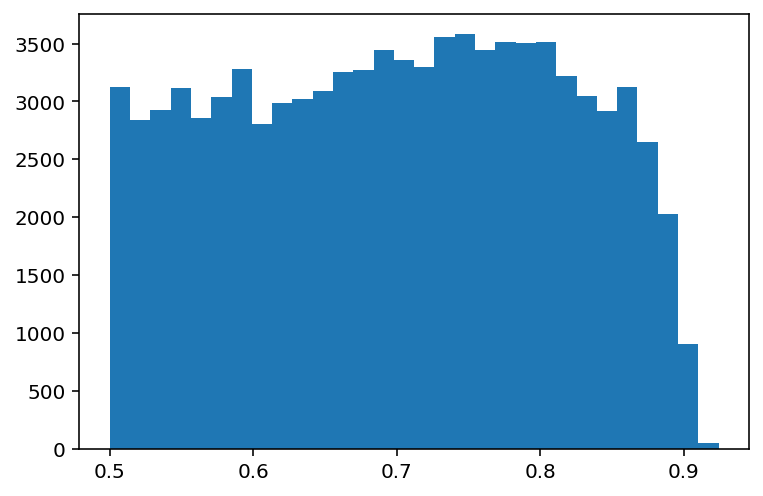

In [137]:
l2g_scores = [y for x in bestgenes_df.bestLocus2Genes_score for y in x]
plt.hist(l2g_scores, bins=30);

In [138]:
np.nanmax(l2g_scores)

0.9243353605270386

In [139]:
l2g_max_scores = [np.nanmax(x) if x else np.nan for x in bestgenes_df.bestLocus2Genes_score]

In [140]:
max_study_idx = np.nanargmax(l2g_max_scores)

In [141]:
bestgenes_df.iloc[[max_study_idx]]

,study,bestGenes_id,bestGenes_symbol,bestColocGenes_id,bestColocGenes_symbol,bestLocus2Genes_id,bestLocus2Genes_symbol,bestLocus2Genes_score,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol,pval,pvalMantissa,pvalExponent,oddsRatio,oddsRatioCILower,oddsRatioCIUpper,beta,betaCILower,betaCIUpper,direction,credibleSetSize,ldSetSize,totalSetSize,variant_id,variant_idB37,variant_rsId,variant_chromosome,variant_position,variant_chromosomeB37,variant_positionB37,variant_refAllele,variant_altAllele,variant_nearestGene_id,variant_nearestGene_symbol,variant_nearestGene_description,variant_nearestGene_chromosome,variant_nearestGene_start,variant_nearestGene_end,variant_nearestGene_tss,variant_nearestGene_bioType,variant_nearestGene_fwdStrand,variant_nearestGene_exons,variant_nearestGeneDistance,variant_nearestCodingGene_id,variant_nearestCodingGene_symbol,variant_nearestCodingGene_description,variant_nearestCodingGene_chromosome,variant_nearestCodingGene_start,variant_nearestCodingGene_end,variant_nearestCodingGene_tss,variant_nearestCodingGene_bioType,variant_nearestCodingGene_fwdStrand,variant_nearestCodingGene_exons,variant_nearestCodingGeneDistance,variant_mostSevereConsequence,variant_caddRaw,variant_caddPhred,variant_gnomadAFR,variant_gnomadAMR,variant_gnomadASJ,variant_gnomadEAS,variant_gnomadFIN,variant_gnomadNFE,variant_gnomadNFEEST,variant_gnomadNFENWE,variant_gnomadNFESEU,variant_gnomadNFEONF,variant_gnomadOTH,variant_nearestGene,variant_nearestCodingGene
113678,NEALE2_23119_raw,"(ENSG00000038427,)","(VCAN,)","(ENSG00000038427,)","(VCAN,)","(ENSG00000038427,)","(VCAN,)","(0.9243353605270386,)","(ENSG00000038427,)","(VCAN,)",2.561800e-09,2.5618,-9,None,None,None,-0.265494,-0.352839,-0.178149,-,4,4,4,5_83515065_T_C,5_82810884_T_C,rs34580448,5,83515065,5,82810884,T,C,ENSG00000038427,VCAN,versican [Source:HGNC Symbol;Acc:HGNC:2464],5,83471618.0,83582303.0,83471618.0,protein_coding,True,"[83471744, 83472023, 83490098, 83490472, 83483...",43447,ENSG00000038427,VCAN,versican [Source:HGNC Symbol;Acc:HGNC:2464],5,83471618.0,83582303.0,83471618.0,protein_coding,True,"[83471744, 83472023, 83490098, 83490472, 83483...",43447,intron_variant,-0.208701,0.675,0.00688389,0.0307329,0.0551724,0,0.0172712,0.0360384,0.0272331,0.0394369,0.00943396,0.042603,0.0275735,NaN,NaN


## Add L2G and closest gene  info to info data frame as a list

In [143]:
bestgenes_df.set_index('study', inplace=True)
info_df.set_index('studyId', inplace=True)

In [144]:
info_df = info_df.join(bestgenes_df.groupby('study')[['bestLocus2GenesOrClosest_id', 'bestLocus2GenesOrClosest_symbol']].agg(lambda x: tuple([i for y in x for i in y])), how='left')
info_df

,traitReported,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumsStats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,nTotal,traitCategory,numAssocLoci,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol
studyId,,,,,,,,,,,,,,,,,,
GCST000001,Age-related macular degeneration,[EFO_0001365],PMID:15761122,2005-03-10,Science,Complement factor H polymorphism in age-relate...,Klein RJ,False,[European=146],[],146,NaN,96,146,Nervous system,1,"(ENSG00000000971,)","(CFH,)"
GCST000002,Parkinson's disease,[EFO_0002508],PMID:16252231,2005-09-09,Am J Hum Genet,High-resolution whole-genome association study...,Maraganore DM,False,"[Asian unspecified=1, European=744, Other=141]","[Other=122, Asian unspecified=1, European=541]",886,664,NaN,1550,Nervous system,0,NaN,NaN
GCST000003,Obesity,[EFO_0001073],PMID:16614226,2006-04-14,Science,A common genetic variant is associated with ad...,Herbert A,False,[NR=694],"[European=10527, African American or Afro-Cari...",694,11622,NaN,12316,Disease,0,NaN,NaN
GCST000004,QT interval,[EFO_0004682],PMID:16648850,2006-04-30,Nat Genet,A common genetic variant in the NOS1 regulator...,Arking DE,False,[European=200],[European=4851],200,4851,NaN,5051,Cardiovascular measurement,1,"(ENSG00000198929,)","(NOS1AP,)"
GCST000005,Parkinson's disease,[EFO_0002508],PMID:17052657,2006-09-28,Lancet Neurol,Genome-wide genotyping in Parkinson's disease ...,Fung HC,False,[European=537],[],537,NaN,267,537,Nervous system,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAIGE_988,Toxic effect of noxious substances eaten as food,[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=408481],[],408481,0,114,408481,Disease,0,NaN,NaN
SAIGE_989,"Toxic effect of other substances, chiefly nonm...",[EFO_0008546],None,2018-10-24,None,None,UKB SAIGE,True,[European=408425],[],408425,0,58,408425,Disease,0,NaN,NaN
SAIGE_990,Effects radiation nos,[EFO_0009658],None,2018-10-24,None,None,UKB SAIGE,True,[European=406425],[],406425,0,3130,406425,Disease,0,NaN,NaN


## Remove duplicates in gene lists using the ids as reference

In [146]:
duplicates = [pd.Series(x).duplicated() + pd.Series(x).isnull() for x in info_df.bestLocus2GenesOrClosest_id]

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [147]:
info_df['bestLocus2GenesOrClosest_id'] = [tuple(np.array(i)[~dup]) if not pd.isnull(i) and i != 'nan' else i for dup, i in zip(duplicates, info_df['bestLocus2GenesOrClosest_id'])]
info_df['bestLocus2GenesOrClosest_symbol'] = [tuple(np.array(i)[~dup]) if not pd.isnull(i) and i != 'nan' else i for dup, i in zip(duplicates, info_df['bestLocus2GenesOrClosest_symbol'])]

In [148]:
'nan' in info_df[~info_df.bestLocus2GenesOrClosest_id.isnull()].explode('bestLocus2GenesOrClosest_id').bestLocus2GenesOrClosest_id.unique()

False

In [149]:
info_df.head(20)

,traitReported,traitEfos,pmid,pubDate,pubJournal,pubTitle,pubAuthor,hasSumsStats,ancestryInitial,ancestryReplication,nInitial,nReplication,nCases,nTotal,traitCategory,numAssocLoci,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol
studyId,,,,,,,,,,,,,,,,,,
GCST000001,Age-related macular degeneration,[EFO_0001365],PMID:15761122,2005-03-10,Science,Complement factor H polymorphism in age-relate...,Klein RJ,False,[European=146],[],146,NaN,96,146,Nervous system,1,"(ENSG00000000971,)","(CFH,)"
GCST000002,Parkinson's disease,[EFO_0002508],PMID:16252231,2005-09-09,Am J Hum Genet,High-resolution whole-genome association study...,Maraganore DM,False,"[Asian unspecified=1, European=744, Other=141]","[Other=122, Asian unspecified=1, European=541]",886,664,NaN,1550,Nervous system,0,NaN,NaN
GCST000003,Obesity,[EFO_0001073],PMID:16614226,2006-04-14,Science,A common genetic variant is associated with ad...,Herbert A,False,[NR=694],"[European=10527, African American or Afro-Cari...",694,11622,NaN,12316,Disease,0,NaN,NaN
GCST000004,QT interval,[EFO_0004682],PMID:16648850,2006-04-30,Nat Genet,A common genetic variant in the NOS1 regulator...,Arking DE,False,[European=200],[European=4851],200,4851,NaN,5051,Cardiovascular measurement,1,"(ENSG00000198929,)","(NOS1AP,)"
GCST000005,Parkinson's disease,[EFO_0002508],PMID:17052657,2006-09-28,Lancet Neurol,Genome-wide genotyping in Parkinson's disease ...,Fung HC,False,[European=537],[],537,NaN,267,537,Nervous system,0,NaN,NaN
GCST000006,Age-related macular degeneration (wet),[EFO_0001365],PMID:17053108,2006-10-19,Science,HTRA1 promoter polymorphism in wet age-related...,Dewan A,False,[South East Asian=226],[],226,NaN,96,226,Nervous system,1,"(ENSG00000254636,)","(ARMS2,)"
GCST000007,Memory performance,[EFO_0004874],PMID:17053149,2006-10-20,Science,Common Kibra alleles are associated with human...,Papassotiropoulos A,False,[European=341],"[African American or Afro-Caribbea, Hispanic o...",341,680,NaN,1021,Mental or behavioural disorder biomarker,0,NaN,NaN
GCST000008,Inflammatory bowel disease,[EFO_0003767],PMID:17068223,2006-10-26,Science,A genome-wide association study identifies IL2...,Duerr RH,False,[European=1095],[Other=1584],1095,1584,547,2679,Immune system,1,"(ENSG00000167207,)","(NOD2,)"
GCST000009,Addiction,[EFO_0003890],PMID:17099884,2006-12-05,Am J Med Genet B Neuropsychiatr Genet,"Addiction molecular genetics: 639,401 SNP whol...",Liu QR,False,"[African American or Afro-Caribbean=920, Europ...",[],1660,NaN,980,1660,Nervous system,0,NaN,NaN


In [150]:
assert np.all([len(x) if not pd.isnull(x) else 0 for x in info_df['bestLocus2GenesOrClosest_id']] == [len(x) if not pd.isnull(x) else 0 for x in info_df['bestLocus2GenesOrClosest_symbol']])

## Sanity check

In [151]:
bestgenes_df[bestgenes_df.index == 'GCST006434_9'][['bestLocus2Genes_id', 'variant_nearestCodingGene_id', 'bestLocus2Genes_symbol', 'variant_nearestCodingGene_symbol', 'bestLocus2GenesOrClosest_id', 'bestLocus2GenesOrClosest_symbol']]

,bestLocus2Genes_id,variant_nearestCodingGene_id,bestLocus2Genes_symbol,variant_nearestCodingGene_symbol,bestLocus2GenesOrClosest_id,bestLocus2GenesOrClosest_symbol
study,,,,,,
GCST006434_9,"(ENSG00000130940,)",ENSG00000130940,"(CASZ1,)",CASZ1,"(ENSG00000130940,)","(CASZ1,)"
GCST006434_9,"(ENSG00000215910,)",ENSG00000215910,"(C1orf167,)",C1orf167,"(ENSG00000215910,)","(C1orf167,)"
GCST006434_9,"(ENSG00000171303,)",ENSG00000171303,"(KCNK3,)",KCNK3,"(ENSG00000171303,)","(KCNK3,)"
GCST006434_9,(),ENSG00000182263,(),FIGN,"(ENSG00000182263,)","(FIGN,)"
GCST006434_9,"(ENSG00000163491,)",ENSG00000163491,"(NEK10,)",NEK10,"(ENSG00000163491,)","(NEK10,)"
GCST006434_9,"(ENSG00000033867,)",ENSG00000033867,"(SLC4A7,)",SLC4A7,"(ENSG00000033867,)","(SLC4A7,)"
GCST006434_9,"(ENSG00000085276,)",ENSG00000085276,"(MECOM,)",MECOM,"(ENSG00000085276,)","(MECOM,)"
GCST006434_9,"(ENSG00000138675,)",ENSG00000138675,"(FGF5,)",FGF5,"(ENSG00000138675,)","(FGF5,)"
GCST006434_9,"(ENSG00000164116,)",ENSG00000061918,"(GUCY1A1,)",GUCY1B1,"(ENSG00000164116,)","(GUCY1A1,)"


## Save objects

In [152]:
'nan' in info_df[~info_df.bestLocus2GenesOrClosest_id.isnull()].explode('bestLocus2GenesOrClosest_id').bestLocus2GenesOrClosest_id.unique()

False

In [153]:
info_df.to_pickle('data/info.pkl')
bestgenes_df.to_pickle('data/bestgenes.pkl')